In [1]:
import torch
import gpytorch
import botorch
from gpytorch.constraints.constraints import Interval

class ExactGPSEModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    """An exact Gaussian process (GP) model with a squared exponential (SE) kernel.

    ExactGP: The base class of gpytorch for any Gaussian process latent function to be
        used in conjunction with exact inference.
    GPyTorchModel: The easiest way to use a GPyTorch model in BoTorch.
        This adds all the api calls that botorch expects in its various modules.

    Attributes:
        train_x: (N x D) The training features X.
        train_y: (N x 1) The training targets y.
        lengthscale_constraint: Constraint for lengthscale of SE-kernel, gpytorch.constraints.
        lengthscale_hyperprior: Hyperprior for lengthscale of SE-kernel, gpytorch.priors.
        outputscale_constraint: Constraint for outputscale of SE-kernel, gpytorch.constraints.
        outputscale_hyperprior: Hyperprior for outputscale of SE-kernel, gpytorch.priors.
        noise_constraint: Constraint for noise, gpytorch.constraints.
        noise_hyperprior: Hyperprior for noise, gpytorch.priors.
        ard_num_dims: Set this if you want a separate lengthscale for each input dimension.
            Should be D if train_x is a N x D matrix.
        prior_mean: Value for constant mean.
    """

    _num_outputs = 1  # To inform GPyTorchModel API.

    def __init__(
        self,
        train_x: torch.Tensor,
        train_y: torch.Tensor,
        lengthscale_constraint=None,
        lengthscale_hyperprior=None,
        outputscale_constraint=None,
        outputscale_hyperprior=None,
        noise_constraint=  Interval(10**(-6),10**(-5)),#None,
        noise_hyperprior=None,
        ard_num_dims=None,
        prior_mean=0,
    ):
        """Inits GP model with data and a Gaussian likelihood."""
        likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=noise_constraint, noise_prior=noise_hyperprior
        )
        if train_y is not None:
            train_y = train_y.squeeze(-1)
        super(ExactGPSEModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean() #gpytorch.means.ConstantMean()
        if prior_mean != 0:
            self.mean_module.initialize(constant=prior_mean)
            self.mean_module.constant.requires_grad = False

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=ard_num_dims,
                lengthscale_prior=lengthscale_hyperprior,
                lengthscale_constraint=lengthscale_constraint,
            ),
            outputscale_prior=outputscale_hyperprior,
            outputscale_constraint=outputscale_constraint,
        )
        # Initialize lengthscale and outputscale to mean of priors.
        if lengthscale_hyperprior is not None:
            self.covar_module.base_kernel.lengthscale = lengthscale_hyperprior.mean
        if outputscale_hyperprior is not None:
            self.covar_module.outputscale = outputscale_hyperprior.mean

    def forward(self, x):
        """Compute the prior latent distribution on a given input.

        Typically, this will involve a mean and kernel function. The result must be a
        MultivariateNormal. Calling this model will return the posterior of the latent
        Gaussian process when conditioned on the training data. The output will be a
        MultivariateNormal.

        Args:
            x: (n x D) The test points.

        Returns:
            A MultivariateNormal.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)




/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DerivativeExactGPSEModel(ExactGPSEModel):
    """Derivative of the ExactGPSEModel w.r.t. the test points x.

    Since differentiation is a linear operator this is again a Gaussian process.

    Attributes:
        D: Dimension of train_x-/input-data.
        normalize: Optional normalization function for policy parameterization.
        unnormalize: Optional unnormalization function for policy
            parameterization.
        N_max: Maximum number of training samples (train_x, N) for model inference.
        lengthscale_constraint: Constraint for lengthscale of SE-kernel, gpytorch.constraints.
        lengthscale_hyperprior: Hyperprior for lengthscale of SE-kernel, gpytorch.priors.
        outputscale_constraint: Constraint for outputscale of SE-kernel, gpytorch.constraints.
        outputscale_hyperprior: Hyperprior for outputscale of SE-kernel, gpytorch.priors.
        noise_constraint: Constraint for noise, gpytorch.constraints.
        noise_hyperprior: Hyperprior for noise, gpytorch.priors.
        ard_num_dims: Set this if you want a separate lengthscale for each input dimension.
            Should be D if train_x is a N x D matrix.
        prior_mean: Value for constant mean.
    """

    def __init__(
        self,
        D: int,
        train_x: torch.Tensor,
        train_y: torch.Tensor,
        normalize=None,
        unnormalize=None,
        N_max=None,
        lengthscale_constraint=None,
        lengthscale_hyperprior=None,
        outputscale_constraint=None,
        outputscale_hyperprior=None,
        noise_constraint= Interval(10**(-6),10**(-5)), #None,
        noise_hyperprior=None,
        ard_num_dims=None,
        prior_mean=0.0,
    ):
        """Inits GP model with data and a Gaussian likelihood."""
        # train_x_init, train_y_init = (
        #     torch.empty(0, D),
        #     torch.empty(0),
        # )
        super(DerivativeExactGPSEModel, self).__init__(
            train_x,
            train_y,
            lengthscale_constraint,
            lengthscale_hyperprior,
            outputscale_constraint,
            outputscale_hyperprior,
            noise_constraint,
            noise_hyperprior,
            ard_num_dims,
            prior_mean,
        )

        self.N_max = N_max
        self.D = D
        self.N = self.train_inputs[0].shape[0] #    self.N = train_x.shape[0]
        
        # self.train_xs = train_x_init
        # self.train_ys = train_y_init
        if normalize is None:
            normalize = lambda params: params
        self.normalize = normalize
        if unnormalize is None:
            unnormalize = lambda params: params
        self.unnormalize = unnormalize

    # def append_train_data(self, train_x, train_y):
    #     """Adaptively append training data.

    #     Optionally translates train_x data for the state normalization of the
    #         MLP.

    #     Args:
    #         train_x: (1 x D) New training features.
    #         train_y: (1 x 1) New training target.
    #     """
    #     self.train_xs = torch.cat([self.unnormalize(train_x), self.train_xs])
    #     self.train_ys = torch.cat([train_y, self.train_ys])

    #     if (self.N_max is not None) or (self.N_max != -1):
    #         # args = torch.argsort(
    #         #    self.covar_module(self.train_xs, self.unnormalize(train_x))
    #         #    .evaluate()
    #         #    .view(-1),
    #         #    descending=False,
    #         # )
    #         # self.train_xs = self.train_xs[args][: self.N_max]
    #         # self.train_ys = self.train_ys[args][: self.N_max]
    #         self.train_xs = self.train_xs[: self.N_max]
    #         self.train_ys = self.train_ys[: self.N_max]

    #     if self.train_ys.size(-1) == 1:
    #         targets = self.train_ys
    #     else:
    #         targets = (self.train_ys - self.train_ys.mean()) / (
    #             self.train_ys.std(unbiased=False) + 1e-10
    #         )

    #     self.set_train_data(
    #         inputs=self.normalize(self.train_xs),
    #         targets=targets,
    #         strict=False,
    #     )

    #     self.N = self.train_xs.shape[0]

    def get_L_lower(self):
        """Get Cholesky decomposition L, where L is a lower triangular matrix.

        Returns:
            Cholesky decomposition L.
        """
        return (
            self.prediction_strategy.lik_train_train_covar.root_decomposition()
            .root.evaluate()
            .detach()
        )

    def get_KXX_inv(self):
        """Get the inverse matrix of K(X,X).

        Returns:
            The inverse of K(X,X).
        """
        L_inv_upper = self.prediction_strategy.covar_cache.detach()
        return L_inv_upper @ L_inv_upper.transpose(0, 1)

    def get_KXX_inv_old(self):
        """Get the inverse matrix of K(X,X).

        Not as efficient as get_KXX_inv.

        Returns:
            The inverse of K(X,X).
        """
        X = self.train_inputs[0]
        sigma_n = self.likelihood.noise_covar.noise.detach()
        return torch.inverse(
            self.covar_module(X).evaluate() + torch.eye(X.shape[0]) * sigma_n
        )

    def _get_KxX_dx(self, x):
        """Computes the analytic derivative of the kernel K(x,X) w.r.t. x.

        Args:
            x: (n x D) Test points.

        Returns:
            (n x D) The derivative of K(x,X) w.r.t. x.
        """
        X = self.train_inputs[0]
        n = x.shape[0]
        K_xX = self.covar_module(x, X).evaluate()
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()
        return (
            -torch.eye(self.D, device=x.device)
            / lengthscale ** 2
            @ (
                (x.view(n, 1, self.D) - X.view(1, self.N, self.D))
                * K_xX.view(n, self.N, 1)
            ).transpose(1, 2)
        )

    def _get_Kxx_dx2(self):
        """Computes the analytic second derivative of the kernel K(x,x) w.r.t. x.

        Args:
            x: (n x D) Test points.

        Returns:
            (n x D x D) The second derivative of K(x,x) w.r.t. x.
        """
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()
        sigma_f = self.covar_module.outputscale.detach()
        return (
            torch.eye(self.D, device=lengthscale.device) / lengthscale ** 2
        ) * sigma_f

    def posterior_derivative(self, x):
        """Computes the posterior of the derivative of the GP w.r.t. the given test
        points x.

        Args:
            x: (n x D) Test points.

        Returns:
            A GPyTorchPosterior.
        """
        if self.prediction_strategy is None:
            self.posterior(x)  # Call this to update prediction strategy of GPyTorch.
        K_xX_dx = self._get_KxX_dx(x)
        mean_d = K_xX_dx @ self.get_KXX_inv() @ self.train_targets
        variance_d = (
            self._get_Kxx_dx2() - K_xX_dx @ self.get_KXX_inv() @ K_xX_dx.transpose(1, 2)
        )
        variance_d = variance_d.clamp_min(1e-9)

        return mean_d, variance_d

In [3]:
import torch
import numpy as np
#from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP,FixedNoiseGP
from botorch.test_functions import Ackley,Beale,Branin,Rosenbrock,SixHumpCamel,Hartmann,Powell,DixonPrice,Levy,StyblinskiTang,Griewank
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement,PosteriorMean,qKnowledgeGradient
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize,normalize
from torch.quasirandom import SobolEngine
from gpytorch.kernels import MaternKernel, RBFKernel, IndexKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.means import ZeroMean
import matplotlib.pyplot as plt

In [4]:
from torch.nn.functional import softplus
import math
from torch import Tensor
from typing import Callable, Tuple, Union

def cauchy(x: Tensor) -> Tensor:
    """Computes a Lorentzian, i.e. an un-normalized Cauchy density function."""
    return 1 / (1 + x.square())

def fatplus(x: Tensor, tau: Union[float, Tensor] = 0.5) -> Tensor:
    """Computes a fat-tailed approximation to `ReLU(x) = max(x, 0)` by linearly
    combining a regular softplus function and the density function of a Cauchy
    distribution. The coefficient `alpha` of the Cauchy density is chosen to guarantee
    monotonicity and convexity.

    Args:
        x: A Tensor on whose values to compute the smoothed function.
        tau: Temperature parameter controlling the smoothness of the approximation.

    Returns:
        A Tensor of values of the fat-tailed softplus.
    """

    def _fatplus(x: Tensor) -> Tensor:
        alpha = 1e-1  # guarantees monotonicity and convexity (TODO: ref + Lemma 4)
        return softplus(x) + alpha * cauchy(x)

    return tau * _fatplus(x / tau)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [16]:
N = 5
iter_num = 30

function = Branin(negate=True)
fstar= 0.
bounds=function.bounds.to(device)
dim = bounds.shape[1]

standard_bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T.to(device)

In [6]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

In [18]:
EI_record_defaultKernel = []

for exp in range(1):

  print(exp)
  torch.manual_seed(exp)

  train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)


  train_x_standard = get_initial_points(dim,4*dim,exp).to(device)
  train_x = unnormalize(train_x_standard, bounds).reshape(-1,dim)
  train_obj = function(train_x).unsqueeze(-1)

  best_value = train_obj.max().item()
  best_value_holder = [best_value]

  for i in range (1):

    train_x_standard = normalize(train_x, bounds).to(device)
    train_obj_standard = (train_obj - train_obj.mean()) / train_obj.std()

    torch.manual_seed(exp+iter_num)
    model = ExactGPSEModel(train_x_standard, train_obj_standard).to(device)

    #model = SingleTaskGP(train_x_standard, train_obj_standard).to(device)
    

    mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

    fit_gpytorch_mll(mll)
    
    # print('lengthscale: ',model.covar_module.base_kernel.lengthscale)
    # print('variance: ',model.covar_module.outputscale )
    
    torch.manual_seed(exp+iter_num)
    EI = ExpectedImprovement(model=model, best_f=train_obj_standard.max().item()) .to(device)

    new_point_analytic, _ = optimize_acqf(
        acq_function=EI,
        bounds=standard_bounds .to(device),
        q=1,
        num_restarts=3*dim,
        raw_samples=30*dim,
        options={},
    )

    #print('EI pciks: ',new_point_analytic)

    next_x = unnormalize(new_point_analytic, bounds).reshape(-1,dim)
    new_obj = function(next_x).unsqueeze(-1) .to(device)

    #print('function value is: ',new_obj)


    train_x = torch.cat((train_x, next_x))
    train_obj = torch.cat((train_obj, new_obj))

    best_value = train_obj.max().item()
    best_value_holder.append(best_value)

    #print(best_value_holder[-1])

  best_value_holder = np.array(best_value_holder)
  EI_record_defaultKernel.append(best_value_holder)

0


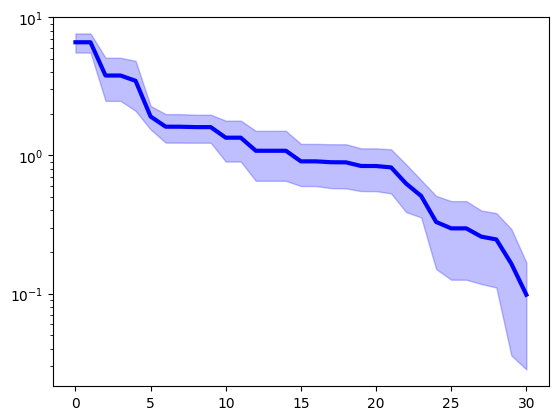

In [42]:
fstar = -0.397887

total_record = (fstar - np.array(EI_record_defaultKernel))
mean = (np.mean(total_record,axis=0))
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))

plt.plot(mean,linewidth=3,label='EI (default kernel)',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

plt.yscale("log") 

# 1d GP check

In [6]:
import GPy

In [7]:
kernel = GPy.kern.RBF(input_dim=1,variance=3,lengthscale=0.15)
m = GPy.models.GPRegression(np.array([0.]).reshape(-1,1),np.array([0.]).reshape(-1,1),kernel)
m.Gaussian_noise.variance.fix(0.1**2)

array([0])

In [8]:
X_total = np.linspace(0,1,200).reshape(-1,1)

np.random.seed(1234)
Y_total = m.posterior_samples_f(X_total,size=1).reshape(-1,1)

In [9]:
delta = X_total[1]-X_total[0]
grad = (Y_total[1:] - Y_total[:-1])/delta

Text(0.5, 1.0, 'GP')

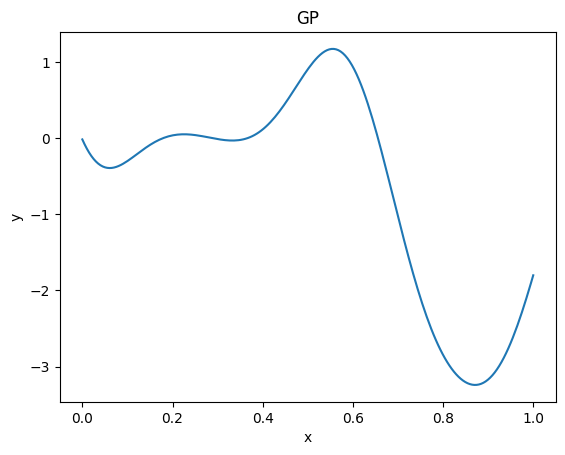

In [11]:
plt.plot(X_total,Y_total)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

Text(0.5, 1.0, 'GP gradient')

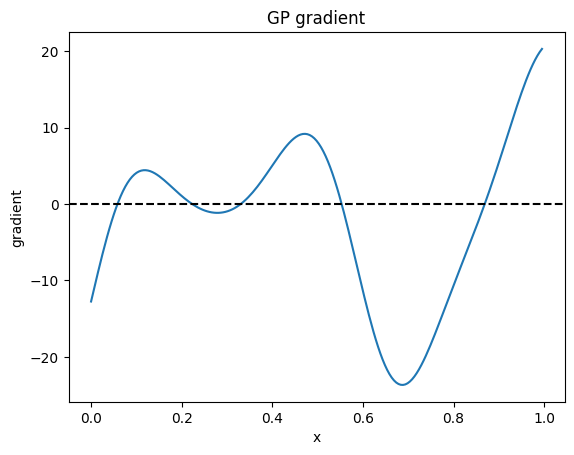

In [12]:
plt.plot(X_total[:-1],grad)
plt.axhline(y=0., color='black', linestyle='--')

plt.xlabel('x')
plt.ylabel('gradient')

plt.title('GP gradient')

Text(0.5, 1.0, 'GP')

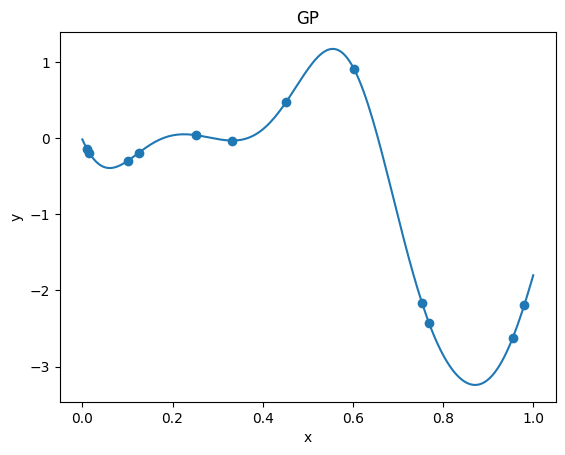

In [13]:
X_train = X_total[[2,3,20,25,50,66,90,120,150,153,190,195]]
Y_train = Y_total[[2,3,20,25,50,66,90,120,150,153,190,195]]

plt.scatter(X_train,Y_train)
plt.plot(X_total,Y_total)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

In [14]:
covar_module =  ScaleKernel(RBFKernel())
model = SingleTaskGP(torch.tensor(X_train).reshape(-1,1), torch.tensor(Y_train).reshape(-1,1),covar_module=covar_module).to(device)

mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

fit_gpytorch_mll(mll)

print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale )

 /home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning:Input data is not standardized. Please consider scaling the input to zero mean and unit variance.


tensor([[0.1666]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
tensor(2.4815, dtype=torch.float64, grad_fn=<SoftplusBackward0>)


In [15]:
model = ExactGPSEModel(torch.tensor(X_train).reshape(-1,1), torch.tensor(Y_train).reshape(-1,1),prior_mean=0).to(device)


mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

fit_gpytorch_mll(mll)

print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale )

tensor([[0.1400]], grad_fn=<SoftplusBackward0>)
tensor(2.6020, grad_fn=<SoftplusBackward0>)


Text(0.5, 1.0, 'GP')

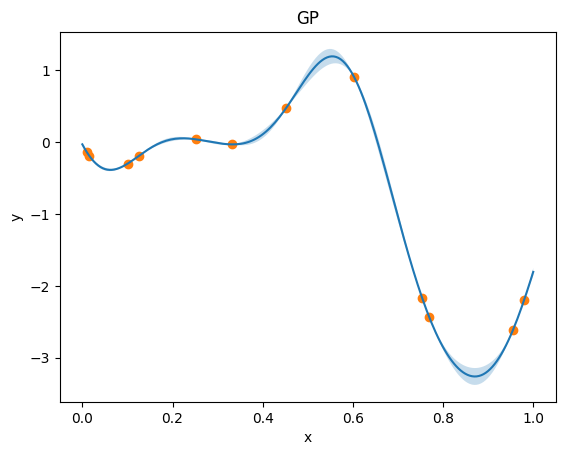

In [16]:
prediction1 = model(torch.tensor(X_total).reshape(-1,1))
pre_mean1 = prediction1.mean.detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(prediction1.variance.detach().numpy()).reshape(-1,)

plt.plot(X_total,pre_mean1 )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.scatter(model.train_inputs[0],model.train_targets)


plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

In [17]:
model = DerivativeExactGPSEModel(1,torch.tensor(X_train).reshape(-1,1), torch.tensor(Y_train).reshape(-1,1)).to(device)
# model.append_train_data(torch.tensor(X_train).reshape(-1,1), torch.tensor(Y_train).reshape(-1,1))

mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

fit_gpytorch_mll(mll)

print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale )

tensor([[0.1400]], grad_fn=<SoftplusBackward0>)
tensor(2.6020, grad_fn=<SoftplusBackward0>)


Text(0.5, 1.0, 'GP')

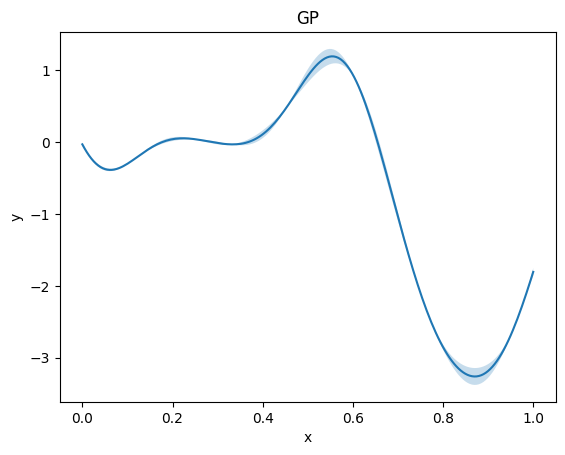

In [18]:
prediction1 = model(torch.tensor(X_total).reshape(-1,1))
pre_mean1 = prediction1.mean.detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(prediction1.variance.detach().numpy()).reshape(-1,)

plt.plot(X_total,pre_mean1 )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

Text(0.5, 1.0, 'GP')

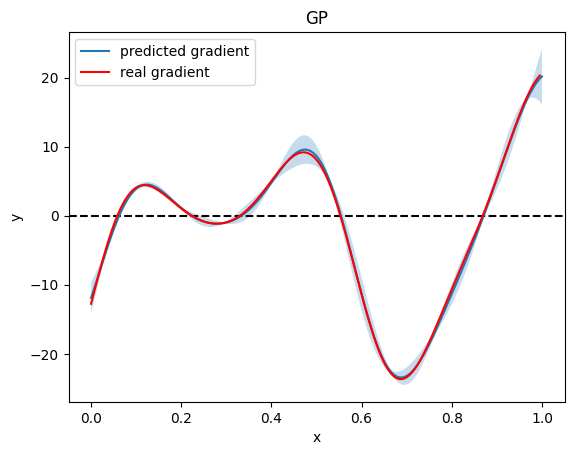

In [19]:
torch.set_default_dtype(dtype)
mean_d, variance_d = model.posterior_derivative(torch.tensor(X_total).reshape(-1,1))

pre_mean1 = mean_d.detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(variance_d.detach().numpy()).reshape(-1,)

plt.axhline(y=0., color='black', linestyle='--')
plt.plot(X_total,pre_mean1,label='predicted gradient' )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.plot(X_total[:-1],grad,label='real gradient',color='red')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

get_fantasy_model is a good way to append data in ExactGP

In [21]:
model_temp = model.get_fantasy_model(torch.tensor([0.85]).reshape(-1,1), torch.tensor([-1.]).reshape(-1,1))
model_temp.N = model.N+1
model_temp.train_targets = model_temp.train_targets.reshape(model_temp.N)

Text(0.5, 1.0, 'GP')

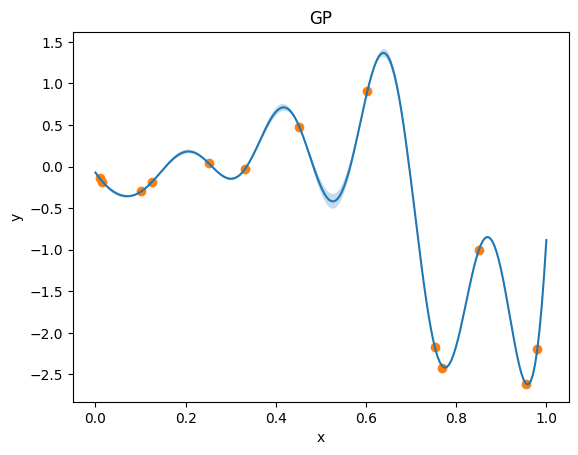

In [22]:
prediction1 = model_temp(torch.tensor(X_total).reshape(-1,1))
pre_mean1 = prediction1.mean.detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(prediction1.variance.detach().numpy()).reshape(-1,)

plt.plot(X_total,pre_mean1 )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.scatter(model_temp.train_inputs[0],model_temp.train_targets)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

In [23]:
model_temp(torch.tensor([0.85]).reshape(-1,1))

MultivariateNormal(loc: tensor([[-1.0077]], grad_fn=<ViewBackward0>))

Text(0.5, 1.0, 'GP')

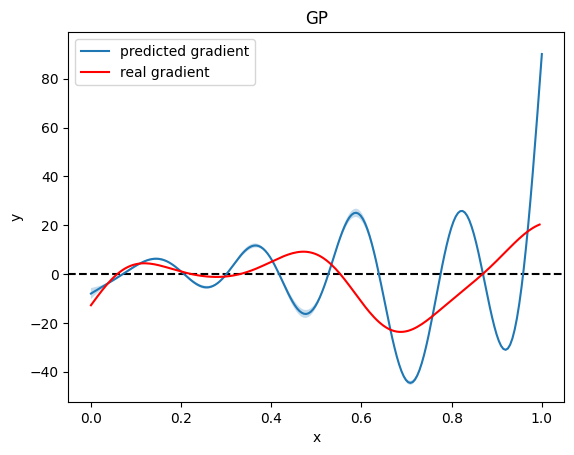

In [24]:
torch.set_default_dtype(dtype)
mean_d, variance_d = model_temp.posterior_derivative(torch.tensor(X_total).reshape(-1,1))

pre_mean1 = mean_d.detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(variance_d.detach().numpy()).reshape(-1,)

plt.axhline(y=0., color='black', linestyle='--')
plt.plot(X_total,pre_mean1,label='predicted gradient' )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.plot(X_total[:-1],grad,label='real gradient',color='red')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

# 2d GP check

In [20]:
def high_dimensional_discretization(bounds,N=50): #bounds shoud always be two dimensional, N is the number of partition in one dimension

  dim = bounds.shape[0]


  bounds = bounds.reshape(dim,-1)
  coords = [np.linspace(bounds[d][0], bounds[d][1], N) for d in range(dim)]
  mesh = np.meshgrid(*coords, indexing='ij')

  coords = np.vstack([x.flatten() for x in mesh]).T

  return coords

In [21]:
X_total = high_dimensional_discretization(np.array([[0.,1.],[0.,1.]]) ,N=51)

In [22]:
kernel = GPy.kern.RBF(input_dim=2,variance=3,lengthscale=0.15)
m = GPy.models.GPRegression(np.array([0.,0.]).reshape(-1,2),np.array([0.]).reshape(-1,1),kernel)
m.Gaussian_noise.variance.fix(0.1**2)

array([0])

In [23]:
np.random.seed(1234)
Y_total = m.posterior_samples_f(X_total,size=1).reshape(-1,1)

 /home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/GPy/core/gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.


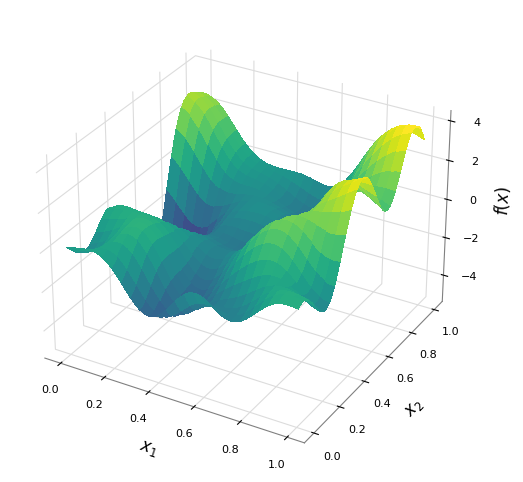

In [24]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import matplotlib as mpl

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figheight(6)
fig.set_figwidth(6)

# Make data.
X1 = np.linspace(0,1,51)
X2 = np.linspace(0,1,51)

X1X2, X2X1 = np.meshgrid(X1,X2)

# Plot the surface.
surf = ax.plot_surface(X1X2, X2X1, Y_total.reshape(51,51), cmap=cm.viridis,
                       linewidth=0.5, antialiased=False)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] = 'gainsboro'
ax.yaxis._axinfo["grid"]['color'] =  'gainsboro'
ax.zaxis._axinfo["grid"]['color'] =  'gainsboro'

ax.xaxis.line.set_color("grey")
ax.yaxis.line.set_color("grey")
ax.zaxis.line.set_color("grey")

ax.set_xlabel('$x_1$', fontsize=12, rotation=150)
ax.set_ylabel('$x_2$', fontsize=12, rotation=150)
ax.set_zlabel(r'$f(x)$', fontsize=12, rotation=50)

ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)

plt.show()

In [69]:
# X_train = X_total[[1,2,20,25,30,40,42,48,61,120,150,300,451,643,987,1111,1259,1500,1651,1996,2112,2400,2500,2521]]
# Y_train = Y_total[[1,2,20,25,30,40,42,48,61,120,150,300,451,643,987,1111,1259,1500,1651,1996,2112,2400,2500,2521]]

X_train = X_total[[1,20,30,48,61,120,150,300,451,643,987,1111,1259,1500,1651,1996,2112,2400,2500,2521]]
Y_train = Y_total[[1,20,30,48,61,120,150,300,451,643,987,1111,1259,1500,1651,1996,2112,2400,2500,2521]]

In [70]:
covar_module =  ScaleKernel(RBFKernel())
model = SingleTaskGP(torch.tensor(X_train).reshape(-1,2), torch.tensor(Y_train).reshape(-1,1),covar_module=covar_module).to(device)

mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

fit_gpytorch_mll(mll)

print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale )

 /home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning:Input data is not standardized. Please consider scaling the input to zero mean and unit variance.


tensor([[0.1298]], grad_fn=<SoftplusBackward0>)
tensor(1.3690, grad_fn=<SoftplusBackward0>)


In [71]:
model = DerivativeExactGPSEModel(2,torch.tensor(X_train).reshape(-1,2), torch.tensor(Y_train).reshape(-1,1)).to(device)
# model.append_train_data(torch.tensor(X_train).reshape(-1,1), torch.tensor(Y_train).reshape(-1,1))

mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

fit_gpytorch_mll(mll)

print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale )

tensor([[0.1303]], grad_fn=<SoftplusBackward0>)
tensor(1.3704, grad_fn=<SoftplusBackward0>)


In [72]:
torch.set_default_dtype(dtype)
mean_d, variance_d = model.posterior_derivative(torch.tensor(X_total).reshape(-1,2))

# pre_mean1 = mean_d.detach().numpy().reshape(-1,)
# pre_std1 = np.sqrt(variance_d.detach().numpy()).reshape(-1,)

Text(0.5, 1.0, 'GP ($x_1=0$)')

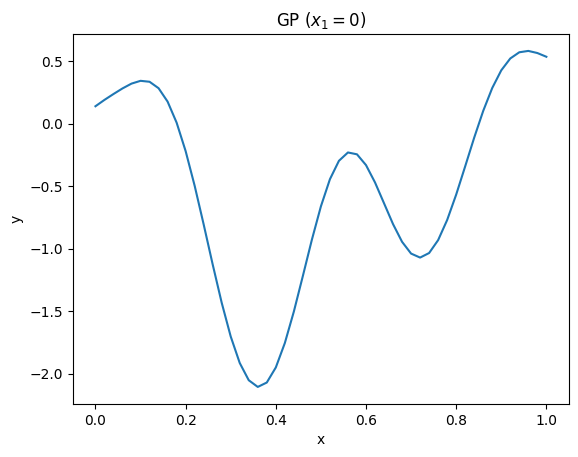

In [73]:
X_part = X_total[:51][:,1]
Y_part = Y_total[:51]

plt.plot(X_part,Y_part)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP ($x_1=0$)')

Text(0.5, 1.0, 'GP gradient ($x_1=0$)')

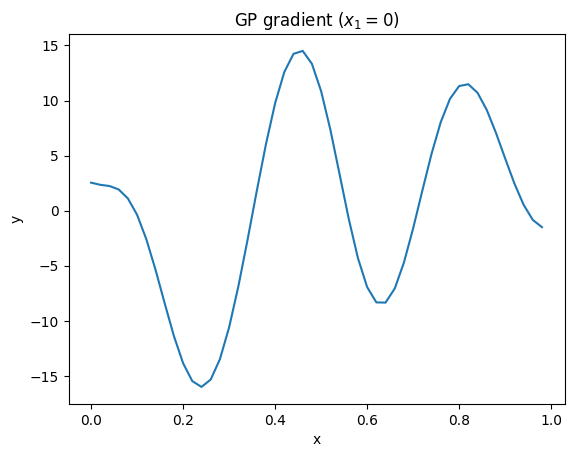

In [74]:
delta = X_part[1]-X_part[0]
grad = (Y_part[1:] - Y_part[:-1])/delta


plt.plot(X_part[:-1],grad)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP gradient ($x_1=0$)')

In [75]:
torch.set_default_dtype(dtype)
mean_d, variance_d = model.posterior_derivative(torch.tensor(X_total[:51]).reshape(-1,2))

# pre_mean1 = mean_d.detach().numpy().reshape(-1,)
# pre_std1 = np.sqrt(variance_d.detach().numpy()).reshape(-1,)

In [76]:
model.posterior_derivative(torch.tensor([0.4,0.5]).reshape(-1,2))

(tensor([[-7.3502,  0.9802]], grad_fn=<UnsafeViewBackward0>),
 tensor([[[36.4212,  1.7943],
          [ 1.7943, 29.9119]]], grad_fn=<ClampMinBackward0>))

In [77]:
type(torch.tensor(X_total[:51]).reshape(-1,2) [0][0])

torch.Tensor

In [78]:
variance_d.shape

torch.Size([51, 2, 2])

In [79]:
variance_d[0]

tensor([[8.0518e+01, 1.0000e-09],
        [1.0000e-09, 5.9190e+01]], grad_fn=<SelectBackward0>)

In [80]:
variance_d[:,-1,-1]

tensor([59.1898, 49.1649, 35.1504, 20.3972,  8.7988,  3.4070,  5.1496, 12.3671,
        21.4483, 28.3229, 30.1404, 26.3622, 18.7960, 10.6380,  5.0540,  3.9763,
         7.5731, 14.4415, 22.2563, 28.5330, 31.2915, 29.5625, 23.7164, 15.5218,
         7.7910,  3.5741,  5.0961, 12.8473, 25.2575, 39.1543, 50.8451, 57.3723,
        57.4342, 51.6551, 42.1941, 31.9405, 23.6299, 19.1466, 19.1331, 22.9252,
        28.7909, 34.4502, 37.8018, 37.6778, 34.3406, 29.4475, 25.4067, 24.3505,
        27.1959, 33.2605, 40.6292], grad_fn=<SelectBackward0>)

Text(0.5, 1.0, 'GP gradient ($x_1=0$)')

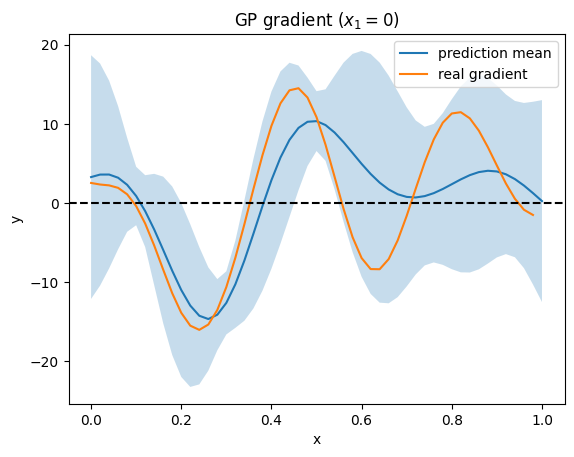

In [81]:
pre_std1 = np.sqrt(variance_d[:,-1,-1].detach().numpy()).reshape(-1,)


plt.plot(X_part,mean_d[:,1].detach().numpy(),label='prediction mean')
plt.fill_between(X_part.reshape(-1,), mean_d[:,1].detach().numpy()-2*pre_std1, mean_d[:,1].detach().numpy()+2*pre_std1,alpha=0.25)

delta = X_part[1]-X_part[0]
grad = (Y_part[1:] - Y_part[:-1])/delta


plt.plot(X_part[:-1],grad,label='real gradient')

pre_std1 = np.sqrt(variance_d.detach().numpy()).reshape(-1,)

plt.axhline(y=0., color='black', linestyle='--')


plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('GP gradient ($x_1=0$)')

# Stationary pdf

In [91]:
variance_d
variance_d_new = torch.diagonal(variance_d, dim1=-2, dim2=-1)
sigma_d_new = variance_d_new.sqrt()

u = (torch.tensor(0.)-mean_d)/sigma_d_new

pdf_total2 = torch.sum(log_phi(u),dim=1)

In [92]:
pdf_total2 = torch.sum(log_phi(u),dim=1)

In [82]:
from botorch.utils.probability.utils import log_phi, ndtr as Phi, phi

In [94]:
D = 2
zeroGradient = 0.

pdf_total = torch.zeros(51)
 
for d in range(D):
    mean_list = mean_d[:,d]
    sigma_list = torch.sqrt(variance_d[:,d,d])
    
    u = (0-mean_list)/sigma_list
    
    max_dis = 20.
    u = fatplus(u+max_dis,tau=0.2)-torch.as_tensor(max_dis) 
    u = - (fatplus(-u+max_dis,tau=0.2)-torch.as_tensor(max_dis))
    
    pdf_temp = log_phi(u)  #log_phi(u)  phi(u)
    
    pdf_total += pdf_temp
    
    #print(pdf_temp)

tensor([-0.9196, -0.9197, -0.9198, -0.9196, -0.9193, -0.9190, -0.9191, -0.9205,
        -0.9247, -0.9343, -0.9522, -0.9829, -1.0318, -1.1056, -1.2119, -1.3558,
        -1.5315, -1.7068, -1.8184, -1.8102, -1.6908, -1.5217, -1.3580, -1.2241,
        -1.1234, -1.0511, -1.0010, -0.9675, -0.9461, -0.9333, -0.9260, -0.9223,
        -0.9205, -0.9198, -0.9194, -0.9193, -0.9192, -0.9190, -0.9189, -0.9195,
        -0.9220, -0.9293, -0.9471, -0.9866, -1.0710, -1.2546, -1.6805, -2.7329,
        -4.6758, -4.5302, -2.8506], grad_fn=<SubBackward0>)
tensor([ -1.0102,  -1.0509,  -1.1041,  -1.1704,  -1.2224,  -1.0373,  -1.0187,
         -1.3691,  -1.7352,  -2.2078,  -2.9159,  -4.0957,  -6.3001, -10.9894,
        -20.5676, -20.8638,  -7.8541,  -2.7408,  -1.2555,  -0.9216,  -1.0531,
         -1.4781,  -2.2627,  -3.8241,  -7.6865, -15.9123, -10.4469,  -4.0126,
         -2.0896,  -1.4300,  -1.1604,  -1.0371,  -0.9772,  -0.9476,  -0.9337,
         -0.9285,  -0.9297,  -0.9393,  -0.9603,  -0.9882,  -1.0179,  -

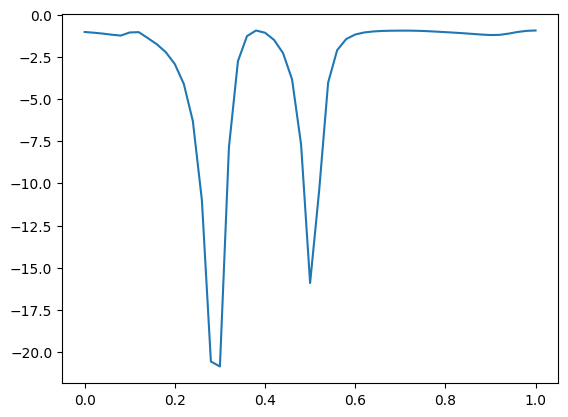

In [95]:
plt.plot(X_part,pdf_temp.detach().numpy(),label='prediction mean')

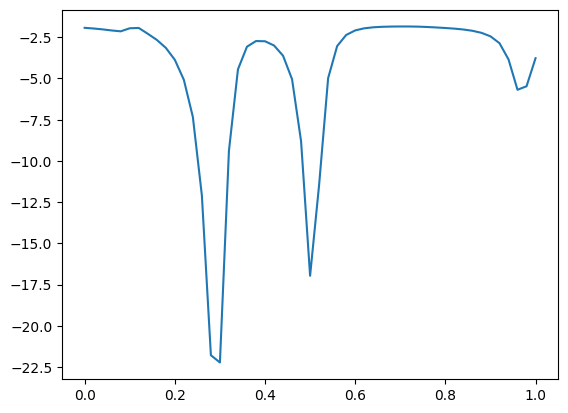

In [96]:
plt.plot(X_part,pdf_total.detach().numpy(),label='prediction mean')
#plt.ylim([-15,0])

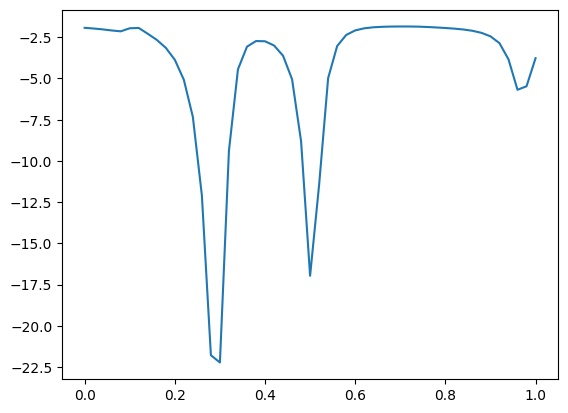

In [97]:
plt.plot(X_part,pdf_total2.detach().numpy(),label='prediction mean')

EI

In [99]:
from scipy.stats import norm
def ei_helper(u):

    return norm.pdf(u)+u*norm.cdf(u)

In [100]:
u = (pre_mean1 - np.max(Y_total[:51]))/pre_std1
AF = pre_std1 * ei_helper(u)

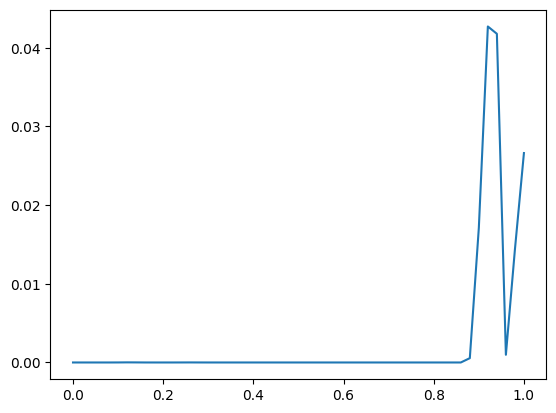

In [101]:
plt.plot(X_part,AF )

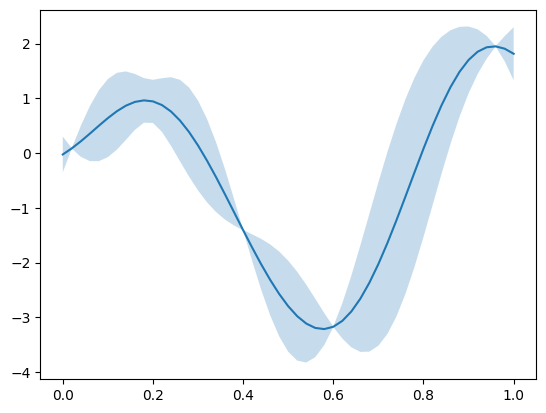

In [116]:
prediction1 = model(torch.tensor(X_total[:51]).reshape(-1,2))
pre_mean1 = prediction1.mean.detach().numpy()
pre_std1 = np.sqrt(prediction1.variance.detach().numpy())

plt.plot(X_part,pre_mean1 )
plt.fill_between(X_part, pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)

In [8]:
N = 1
iter_num = 30

function = Branin(negate=True)
fstar= -0.397887
bounds=function.bounds.to(device)
dim = bounds.shape[1]

standard_bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T.to(device)

EI_record = []

for exp in range(1):

  print(exp)
  torch.manual_seed(exp)

  train_x_standard = get_initial_points(dim,4*dim,exp).to(device)
  train_x = unnormalize(train_x_standard, bounds).reshape(-1,dim)
  train_obj = function(train_x).unsqueeze(-1)

  best_value = train_obj.max().item()
  best_value_holder = [best_value]

  for i in range (1):

    train_x_standard = normalize(train_x, bounds).to(device)
    train_obj_standard = (train_obj - train_obj.mean()) / train_obj.std()

    torch.manual_seed(exp+iter_num)
    model = DerivativeExactGPSEModel(dim,train_x_standard, train_obj_standard).to(device)


0


In [9]:
model.posterior_derivative(torch.tensor([0.4,0.5]).reshape(-1,2))

RuntimeError: expected scalar type Float but found Double

In [3]:
import torch
from torch import finfo, Tensor
finfo(torch.tensor([0.123]).dtype).tiny

1.1754943508222875e-38

In [35]:
from torch.nn.functional import softplus
import math

from typing import Callable, Tuple, Union

def cauchy(x: Tensor) -> Tensor:
    """Computes a Lorentzian, i.e. an un-normalized Cauchy density function."""
    return 1 / (1 + x.square())

def fatplus(x: Tensor, tau: Union[float, Tensor] = 0.5) -> Tensor:
    """Computes a fat-tailed approximation to `ReLU(x) = max(x, 0)` by linearly
    combining a regular softplus function and the density function of a Cauchy
    distribution. The coefficient `alpha` of the Cauchy density is chosen to guarantee
    monotonicity and convexity.

    Args:
        x: A Tensor on whose values to compute the smoothed function.
        tau: Temperature parameter controlling the smoothness of the approximation.

    Returns:
        A Tensor of values of the fat-tailed softplus.
    """

    def _fatplus(x: Tensor) -> Tensor:
        alpha = 1e-1  # guarantees monotonicity and convexity (TODO: ref + Lemma 4)
        return softplus(x) + alpha * cauchy(x)

    return tau * _fatplus(x / tau)

In [41]:
from torch.nn.functional import softplus

X = torch.tensor([[-28.],[12.]])
softplus(X)

tensor([[6.9144e-13],
        [1.2000e+01]])

In [42]:
fatplus(X+15)-torch.as_tensor(15)

tensor([[-14.9999],
        [ 12.0000]])

In [44]:
- (fatplus(-X+10)-torch.as_tensor(10))

tensor([[-28.0000],
        [  9.9880]])

In [13]:
dim = 2
bounds=np.array([0.,1.]*dim).reshape(-1,2)
init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))

In [14]:
init_X

array([[0.18938119, 0.47119615],
       [0.06110995, 0.76646073],
       [0.8929137 , 0.15852258],
       [0.11409138, 0.64409401],
       [0.39970616, 0.18110959],
       [0.13258395, 0.64924352],
       [0.03888245, 0.41146654],
       [0.36500671, 0.9942564 ],
       [0.83750937, 0.20508431],
       [0.51179019, 0.73500268],
       [0.80192868, 0.63315628],
       [0.54543748, 0.55772472],
       [0.70567328, 0.32879192],
       [0.58431013, 0.81583793],
       [0.00529467, 0.62573422],
       [0.50233127, 0.41190941],
       [0.22755583, 0.04397102],
       [0.39079707, 0.29638056],
       [0.57686763, 0.1346584 ],
       [0.85690637, 0.50453689],
       [0.14501911, 0.06181716],
       [0.89020453, 0.54146733],
       [0.39010515, 0.91920036],
       [0.78219017, 0.62732025],
       [0.63858173, 0.01188936],
       [0.39234893, 0.45550803],
       [0.24269046, 0.0268485 ],
       [0.2139959 , 0.3215352 ],
       [0.07487419, 0.95824592],
       [0.29377756, 0.34172611],
       [0.

In [22]:
EI(torch.tensor(init_X).reshape(-1,1,dim)).detach().numpy().shape

(60,)